In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

plt.rcParams['figure.figsize'] = (12, 6)

In [14]:
df = pd.read_csv('../data/ncr_ride_bookings.csv')


# 1. Criar a variável alvo (target): 'foi_cancelado'
#    1 se foi cancelado (pelo cliente ou motorista), 0 se foi completado.
df['foi_cancelado'] = df['Booking Status'].apply(lambda x: 1 if 'Cancelled' in x else 0)

# 2. Engenharia de Features de Hora
df['BookingTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df['Hour'] = df['BookingTime'].dt.hour
df['DayOfWeek'] = df['BookingTime'].dt.dayofweek # 0=Segunda, 1=Terça...

# 3. Seleção de Features Iniciais (Variáveis Preditivas)
#    Vamos usar um conjunto inicial de features que fazem sentido no momento da reserva.
features = [
    'Hour',
    'DayOfWeek',
    'Vehicle Type',
    'Avg VTAT', # Tempo médio para o motorista chegar
    'Avg CTAT', # Duração média estimada da viagem
    'Booking Value',
    'Ride Distance'
]

target = 'foi_cancelado'

# Criar um novo DataFrame apenas com as colunas que vamos usar
df_model = df[features + [target]].copy()

# 4. Converter Variáveis Categóricas em Numéricas (One-Hot Encoding)
#    O modelo de ML só entende números.
df_model = pd.get_dummies(df_model, columns=['Vehicle Type'], drop_first=True)

# 5. Limpeza de Dados Faltantes (se houver)
#    Para este exemplo, vamos preencher qualquer valor nulo com a mediana da coluna.
for col in df_model.columns:
    if df_model[col].isnull().any():
        median_value = df_model[col].median()
        df_model[col].fillna(median_value, inplace=True)

print("Pré-processamento concluído. Features prontas para o modelo:")
display(df_model.head())

Pré-processamento concluído. Features prontas para o modelo:


C:\Users\Vinicius\AppData\Local\Temp\ipykernel_16996\2814771414.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_model[col].fillna(median_value, inplace=True)
C:\Users\Vinicius\AppData\Local\Temp\ipykernel_16996\2814771414.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


,Hour,DayOfWeek,Avg VTAT,Avg CTAT,Booking Value,Ride Distance,foi_cancelado,Vehicle Type_Bike,Vehicle Type_Go Mini,Vehicle Type_Go Sedan,Vehicle Type_Premier Sedan,Vehicle Type_Uber XL,Vehicle Type_eBike
0,12,5,8.3,28.8,414.0,23.72,0,False,False,False,False,False,True
1,18,4,4.9,14.0,237.0,5.73,0,False,False,True,False,False,False
2,8,4,13.4,25.8,627.0,13.58,0,False,False,False,False,False,False
3,17,0,13.1,28.5,416.0,34.02,0,False,False,False,True,False,False
4,22,0,5.3,19.6,737.0,48.21,0,True,False,False,False,False,False


In [15]:
# Separar as features (X) da variável alvo (y)
X = df_model.drop(target, axis=1)
y = df_model[target]

# Dividir os dados: 70% para treino, 30% para teste
# stratify=y garante que a proporção de cancelados/completados seja a mesma nos dois conjuntos.
# random_state=42 garante que a divisão seja sempre a mesma, para reprodutibilidade.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.33333,
    random_state=42,
    stratify=y
)

print("Dados divididos em conjuntos de treino e teste:")
print(f"Tamanho do treino: {X_train.shape[0]} amostras")
print(f"Tamanho do teste: {X_test.shape[0]} amostras")

Dados divididos em conjuntos de treino e teste:
Tamanho do treino: 100000 amostras
Tamanho do teste: 50000 amostras


In [16]:
# n_estimators=100 significa que ele é composto por 100 "árvores de decisão".
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Agora, vamos "ensinar" o modelo usando os dados de treino.
print("Iniciando o treinamento do modelo...")
model.fit(X_train, y_train)
print("Treinamento concluído!")

Iniciando o treinamento do modelo...
Treinamento concluído!


Acurácia do Modelo: 99.74%



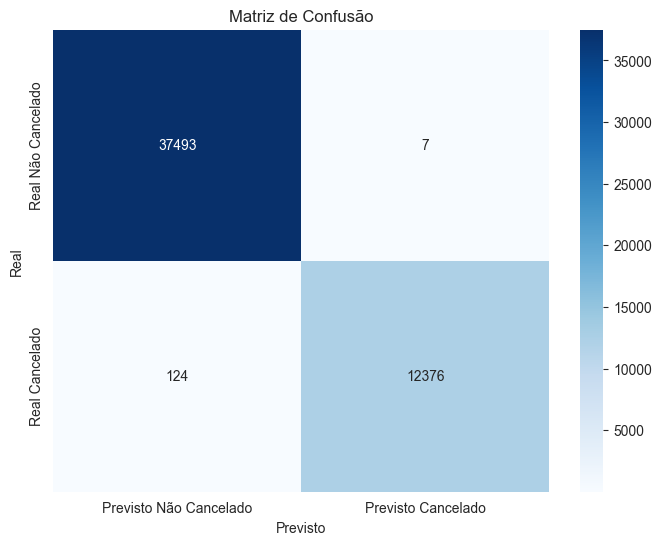


Relatório de Classificação:
                   precision    recall  f1-score   support

Não Cancelado (0)       1.00      1.00      1.00     37500
    Cancelado (1)       1.00      0.99      0.99     12500

         accuracy                           1.00     50000
        macro avg       1.00      0.99      1.00     50000
     weighted avg       1.00      1.00      1.00     50000



In [17]:
y_pred = model.predict(X_test)

# 1. Acurácia
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia do Modelo: {accuracy:.2%}\n")

# 2. Matriz de Confusão (o gabarito detalhado)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Previsto Não Cancelado', 'Previsto Cancelado'],
            yticklabels=['Real Não Cancelado', 'Real Cancelado'])
plt.title('Matriz de Confusão')
plt.ylabel('Real')
plt.xlabel('Previsto')
plt.show()

# 3. Relatório de Classificação (Precisão, Recall, F1-Score)
#    Este é o relatório mais completo e importante.
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=['Não Cancelado (0)', 'Cancelado (1)']))

In [18]:
# A validação cruzada nos dá uma ideia mais confiável do desempenho do modelo.
print("Executando a Validação Cruzada (5-folds)...")

# Usamos o f1_weighted para ter uma métrica única que considera o desbalanceamento das classes
scores = cross_val_score(model, X, y, cv=5, scoring='f1_weighted', n_jobs=-1)

print("\nResultados da Validação Cruzada:")
print(f"Pontuações F1 em cada fold: {scores}")
print(f"Média do F1-Score: {scores.mean():.4f}")
print(f"Desvio Padrão do F1-Score: {scores.std():.4f}")

# INSIGHT: Se a média da validação cruzada for próxima do resultado que obtivemos no teste único,
#          é um bom sinal de que nosso modelo é estável e não tivemos "sorte" na divisão dos dados.

Executando a Validação Cruzada (5-folds)...

Resultados da Validação Cruzada:
Pontuações F1 em cada fold: [0.99736248 0.99722843 0.99706154 0.99706101 0.99709552]
Média do F1-Score: 0.9972
Desvio Padrão do F1-Score: 0.0001
